<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analysis & Numerical Optimization**

Differential Calculus

## **Import Libraries & Data**

In [0]:
!pip install livelossplot --quiet

import tensorflow as tf
import datetime, os
from livelossplot import PlotLossesKeras

# Populating the interactive namespace from numpy and matplotlib
# %pylab inline
import numpy as np
from mpl_toolkits import mplot3d
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
import math 

print(tf.__version__)

2.2.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# **Differential Calculus**

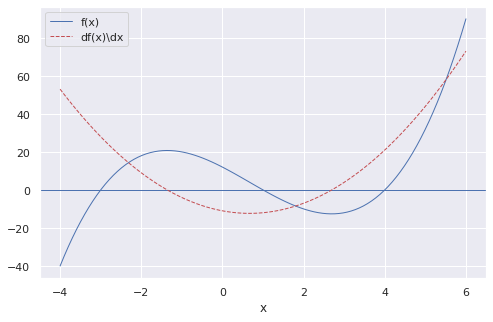

In [0]:
import seaborn as sns

sns.set(rc={'figure.figsize':(8, 5), "lines.linewidth": 1.0})

#Defining the functions and its first derivative
def f(x):
    return x**3 - 2*x**2 - 11*x + 12

def dfdx(x):
    return 3*x**2 - 4*x - 11
    
#Initializing data
x = np.linspace(-4,6,100)
y = f(x)
y_dash = dfdx(x)

#Plotting the function and its derivative
#fig = plt.figure()
plt.xlabel('x')
plt.axhline(0)
plt.plot(x,y, label = 'f(x)')
plt.plot(x,y_dash, '--r', label = 'df(x)\dx')
plt.legend()
plt.show()

# **Test Functions for Optimization**

Optimization - Descent Algorithms

## **Functions to minimize**

**Rosenbrock**'s function and **Himmelblau**'s function are comonly used to test optimization algorithms. We shall use them all along.

You can find other functions to test here: https://en.wikipedia.org/wiki/Test_functions_for_optimization

* Omar Aflak
* aflakomar@gmail.com
* [github.com/omaraflak](https://github.com/omaraflak)
* [medium.com/@omaraflak](https://medium.com/@omaraflak)

### **Rosenbrock function**

https://en.wikipedia.org/wiki/Rosenbrock_function

$f(x,y) = (a - x)^2 + b * (y - x^2)^2$

It has a global minimum at $(x,y)=(a,a^2)$, where $f(x,y)=0$.

In [0]:
def rosenbrock(X, a=1, b=100):
    x, y = X
    return (a - x)**2 + b * (y - x**2)**2

def rosenbrock_grad(X, a=1, b=100):
    x, y = X
    return np.array([
        2 * (x - a) - 4 * b * x * (y - x**2),
        2 * b * (y - x**2)
    ])

def rosenbrock_hess(X, a=1, b=100):
    x, y = X
    return np.matrix([
        [2 - 4 * b * (y - 3 * x**2), -4 * b * x],
        [-4 * b * x, 2 * b]
    ])

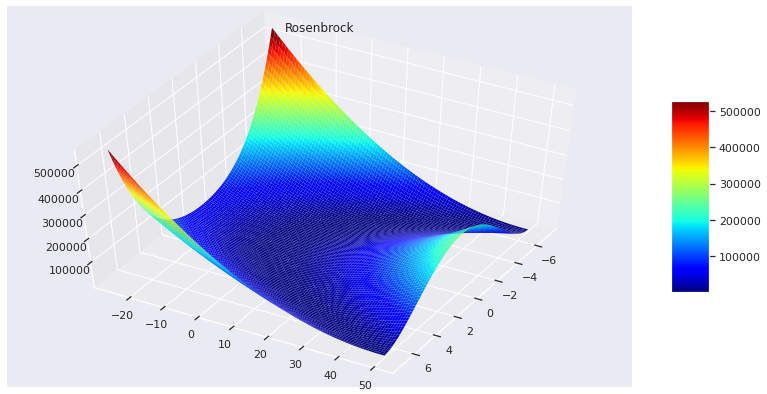

In [0]:
x = np.linspace(-7, 7, 100)
y = np.linspace(-25, 50, 100)
X, Y = np.meshgrid(x, y)
Z = rosenbrock((X, Y))

fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection='3d')
ax.set_title('Rosenbrock')
ax.view_init(elev=50., azim=30)
s = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='jet', edgecolor='none')
fig.colorbar(s, shrink=0.5, aspect=5)

### **Himmelblau's function**

https://en.wikipedia.org/wiki/Himmelblau%27s_function

$f(x,y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2$

The Himmelblau's function has one local maximum at $(x,y) = (-0.270845, -0.923039)$ where $f(x,y)=181.617$, and four identical local minima:

$
f(3.0,2.0)=0 \\
f(-2.805118,3.131312)=0 \\
f(-3.779310,-3.283186)=0 \\ 
f(3.584428,-1.848126)=0
$

In [0]:
def himmelblau(X):
    x, y = X
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

def himmelblau_grad(X):
    x, y = X
    return np.array([
        4 * x * (x**2 + y - 11) + 2 * (x + y**2 - 7),
        2 * (x**2 + y - 11) + 4 * y * (x + y**2 - 7)
    ])

def himmelblau_hess(X):
    x, y = X
    return np.array([
        [2 - 400 * (y - 3 * x**2), -400 * x],
        [-400 * x, 200]
    ])

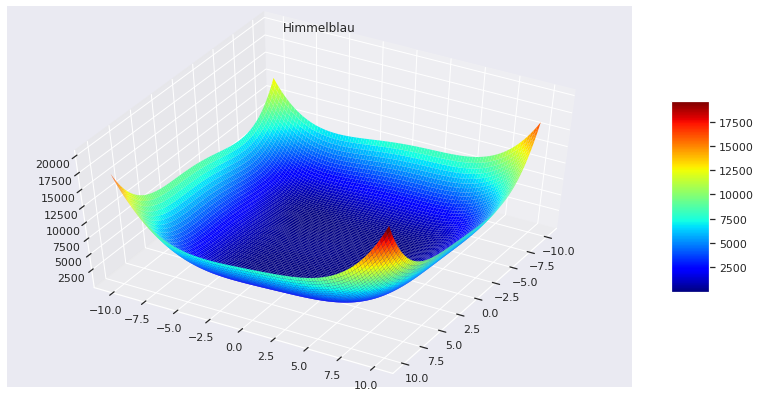

In [0]:
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z = himmelblau((X, Y))

fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection='3d')
ax.set_title('Himmelblau')
ax.view_init(elev=50., azim=30)
s = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='jet', edgecolor='none')
fig.colorbar(s, shrink=0.5, aspect=5)

### **Easom function**

$f(x,y) = -cos(x)cos(y)exp(-(x-\pi)^2 - (y-\pi)^2)$

$f$ has a global minimum in $(x,y) = (\pi,\pi)$, where $f(\pi, \pi) = -1$.

In [0]:
def easom(X):
    x, y = X
    return -np.cos(x) * np.cos(y) * np.exp(-(x - np.pi)**2 -(y - np.pi)**2)

def easom_grad(X):
    x, y = X
    return np.array([
        np.cos(y) * np.exp(-(x - np.pi)**2 -(y - np.pi)**2) * (np.sin(x) + 2 * np.cos(x)),
        np.cos(x) * np.exp(-(y - np.pi)**2 -(x - np.pi)**2) * (np.sin(y) + 2 * np.cos(y))
    ])

# still have to add the hessian

In [0]:
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z = easom((X, Y))

fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection='3d')
ax.set_title('Easom')
ax.view_init(elev=20., azim=30)
s = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='jet', edgecolor='none')
fig.colorbar(s, shrink=0.5, aspect=5)

## **Newton's direction**

$
d = - H_f^{-1}(x) \cdot \nabla_xf(x) \\
H_f(x) = \begin{bmatrix}
\frac{\partial^2 f}{\partial x_1^2} & \cdots & \frac{\partial^2 f}{\partial x_1 \partial x_n} \\
\vdots & \ddots & \vdots \\
\frac{\partial^2 f}{\partial x_n \partial x_1} & \cdots & \frac{\partial^2 f}{\partial x_n^2}
\end{bmatrix}, \quad
\nabla_xf(x) = \begin{bmatrix}
\frac{\partial f}{\partial x_1} \\
\vdots \\
\frac{\partial f}{\partial x_n}
\end{bmatrix}
$


In [0]:
def newton(J_grad, J_hess, x_init, epsilon=1e-10, max_iterations=1000):
    x = x_init
    for i in range(max_iterations):
        x = x - np.linalg.solve(J_hess(x), J_grad(x))
        if np.linalg.norm(J_grad(x)) < epsilon:
            return x, i + 1
    return x, max_iterations

In [0]:
# The Rosenbrock function takes 2 inputs
x_init = np.zeros(2)
x_min, it = newton(rosenbrock_grad, rosenbrock_hess, x_init)
print('x* =', x_min)
print('Rosenbrock(x*) =', rosenbrock(x_min))
print('Grad Rosenbrock(x*) =', rosenbrock_grad(x_min))
print('Iterations =', it)

In [0]:
# The Himmelblau function takes 2 inputs
x_init = np.zeros(2)
x_min, it = newton(himmelblau_grad, himmelblau_hess, x_init, max_iterations=2000)
print('x* =', x_min)
print('Himmelblau(x*) =', himmelblau(x_min))
print('Grad Himmelblau(x*) =', himmelblau_grad(x_min))
print('Iterations =', it)

## **Gradient's direction**

$
d = - \nabla_xf(x) \\
\nabla_xf(x) = \begin{bmatrix}
\frac{\partial f}{\partial x_1} \\
\vdots \\
\frac{\partial f}{\partial x_n}
\end{bmatrix}
$

In [0]:
def gradient_descent(J_grad, x_init, alpha=0.01, epsilon=1e-10, max_iterations=1000):
    x = x_init
    for i in range(max_iterations):
        x = x - alpha * J_grad(x)
        if np.linalg.norm(J_grad(x)) < epsilon:
            return x, i + 1
    return x, max_iterations

In [0]:
# Rosenbrock takes 2 input variables that we set to 0 at first
x_init = np.zeros(2)
x_min, it = gradient_descent(rosenbrock_grad, x_init, alpha=0.002, max_iterations=5000)
print('x* =', x_min)
print('Rosenbrock(x*) =', rosenbrock(x_min))
print('Grad Rosenbrock(x*) =', rosenbrock_grad(x_min))
print('Iterations =', it)

In [0]:
# The Himmelblau function takes 2 inputs
x_init = np.zeros(2)
x_min, it = gradient_descent(himmelblau_grad, x_init)
print('x* =', x_min)
print('Himmelblau(x*) =', himmelblau(x_min))
print('Grad Himmelblau(x*) =', himmelblau_grad(x_min))
print('Iterations =', it)

## **Gradient's direction + Optimal step size**

$
d = - \alpha \nabla_xf(x) \\
\nabla_xf(x) = \begin{bmatrix}
\frac{\partial f}{\partial x_1} \\
\vdots \\
\frac{\partial f}{\partial x_n}
\end{bmatrix}, \quad \alpha \in {\Bbb R}
$

$\alpha$ is the step size, usually in the range $[0,1]$. Unlike the usual gradient descent, here we want to find the optimal $\alpha$ at every iteration. Since at every step, the update is:

$x_{k+1} = x_k - \alpha \nabla_xf(x_k)$

We want to make sure, that the chosen $\alpha$ is going to minimize as much as possible the target function $f$. Therefore, we want $\alpha$ to be such that:

$\alpha_k = \underset{\alpha}{argmin} f(x_k - \alpha \nabla_xf(x_k))$

Since at iteration $k$, $x_k$ and $\nabla_xf(x_k)$ are constants, we can define $q(\alpha)$:

$q(\alpha) = f(x_k - \alpha \nabla_xf(x_k))$

that is a function of one variable, $\alpha$. Therefore, we want to find the right $\alpha$ that will minimize $q$. That task can be solved for instance using gradient descent itself, but since we know that $/alpha$ is bounded, we are going to use another algorithm more suited for this task: Golden Section Search.

https://en.wikipedia.org/wiki/Golden-section_search

In [0]:
def gss(f, a, b, tol=1e-7):
    phi = (np.sqrt(5) + 1) / 2
    d = b - (b - a) / phi
    c = a + (b - a) / phi

    while abs(d - c) > tol:
        if f(d) < f(c):
            b = c
        else:
            a = d

        d = b - (b - a) / phi
        c = a + (b - a) / phi

    return (a + b) / 2

def gradient_descent_optimal(J, J_grad, x_init, epsilon=1e-10, max_iterations=1000):
    x = x_init
    for i in range(max_iterations):
        q = lambda alpha: J(x - alpha * J_grad(x))
        alpha = gss(q, 0, 1)
        x = x - alpha * J_grad(x)
        if np.linalg.norm(J_grad(x)) < epsilon:
            return x, i + 1
    return x, max_iterations

In [0]:
# The Rosenbrock function takes 2 inputs
x_init = np.zeros(2)
x_min, it = gradient_descent_optimal(rosenbrock, rosenbrock_grad, x_init, max_iterations=3000)
print('x* =', x_min)
print('Rosenbrock(x*) =', rosenbrock(x_min))
print('Grad Rosenbrock(x*) =', rosenbrock_grad(x_min))
print('Iterations =', it)

In [0]:
# The Himmelblau function takes 2 inputs
x_init = np.zeros(2)
x_min, it = gradient_descent_optimal(himmelblau, himmelblau_grad, x_init)
print('x* =', x_min)
print('Himmelblau(x*) =', himmelblau(x_min))
print('Grad Himmelblau(x*) =', himmelblau_grad(x_min))
print('Iterations =', it)

# **Optimizer**


* why optimizer
* what is it doing

https://medium.com/explorations-in-language-and-learning/a-short-note-on-gradient-descent-optimization-algorithms-335546c5a896


An overview of gradient descent optimization algorithms

https://arxiv.org/pdf/1609.04747.pdf

**Which Optimizer to use?**

* Wich optimizer should you now use? If your input data is sparse, then you likely achieve the best results using one of the adaptive learning-rate methods. An additional benefit is that you won't need to tune the learning rate but likely achieve the best results with the default value.
* In summary, RMSprop is an extension of Adagrad that deals with its radically diminishing learning rates. It is identical to Adadelta, except that Adadelta uses the RMS of parameter updates in the numinator update rule. Adam, finally, adds bias-correction and momentum to RMSprop. Insofar, RMSprop, Adadelta, and Adam are very similar algorithms that do well in similar circumstances. Kingma et al. [15] show that its bias-correction helps Adam slightly outperform RMSprop towards the end of optimization as gradients become sparser. Insofar, Adam might be the best overall choice.
* Interestingly, many recent papers use vanilla SGD without momentum and a simple learning rate annealing schedule. As has been shown, SGD usually achieves to find a minimum, but it might take significantly longer than with some of the optimizers, is much more reliant on a robust initialization and annealing schedule, and may get stuck in saddle points rather than local minima. Consequently, if you care about fast convergence and train a deep or complex neural network, you should choose one of the adaptive learning rate methods.

**Comparison**

* Few days ago, an interesting paper titled The Marginal Value of Adaptive Gradient Methods in Machine Learning (https://arxiv.org/abs/1705.08292) from UC Berkeley came out. In this paper, the authors compare adaptive optimizer (Adam, RMSprop and AdaGrad) with SGD, observing that SGD has better generalization than adaptive optimizers.
* “We observe that the solutions found by adaptive methods generalize worse (often significantly worse) than SGD, even when these solutions have better training performance. These results suggest that practitioners should reconsider the use of adaptive methods to train neural networks.”
* I was astounded by their finding since I never used SGD before and consider it as an outdated optimizer with slower convergence than Adam or RMSprop. Am I totally wrong from the very beginning?

![Optimizer](https://raw.githubusercontent.com/deltorobarba/repo/master/optimizer_4.png)

https://medium.com/vitalify-asia/whats-up-with-deep-learning-optimizers-since-adam-5c1d862b9db0


## **SGD**

(Stochastic Gradient Descent)

* [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) documentation
* Nesterov algorithm based on [this paper](http://jmlr.org/proceedings/papers/v28/sutskever13.pdf)

**Characteristics**
* SGD is a stochastic approximation of the gradient descent optimization and iterative method for minimizing an objective function that is written as a sum of differentiable functions. All other optimizers are called „adaptive“, because they have momentum.
* A compromise between computing the true gradient and the gradient at a single example is to compute the gradient against more than one training example (called a "mini-batch") at each step. This can perform significantly better than "true" stochastic gradient descent described, because the code can make use of vectorization libraries rather than computing each step separately. It may also result in smoother convergence, as the gradient computed at each step uses more training examples.
* The convergence of stochastic gradient descent has been analyzed using the theories of convex minimization and of stochastic approximation. Briefly, when the learning rates decrease with an appropriate rate, and subject to relatively mild assumptions, stochastic gradient descent converges almost surely to a global minimum when the objective function is convex or pseudoconvex, and otherwise converges almost surely to a local minimum.[3][4] This is in fact a consequence of the Robbins-Siegmund theorem.
* SGD suffers from 2 problems: (i) being hesitant at steep slopes, and (ii) having same learning rate for all parameters.

**Formula**

$\theta=\theta-\eta \cdot \nabla_{\theta} J\left(\theta ; x^{(i)} ; y^{(i)}\right)$

* Stochastic gradient descent (SGD) in contrast performs a parameter update for each training example $x^{(i)}$ and label $y^{(i)}$
* Batch gradient descent performs redundant computations for large datasets, as it recomputes gradients for similar examples before each parameter update. SGD does away with this redundancy by performing one update at a time. It is therefore usually much faster and can also be used to learn online. 
* SGD performs frequent updates with a high variance that cause the objective function to fluctuate heavily.

**SGD Optimizer Components**

* **learning_rate**: float hyperparameter >= 0. Learning rate.
* **momentum**: float hyperparameter >= 0 that accelerates SGD in the relevant direction and dampens oscillations.
* **nesterov**: boolean. Whether to apply Nesterov momentum.

**// Extension: SGD with Momentum**

**Characteristics**
* The update vector consists of another term which has the previous update vector (weighted by γ). This helps it to move faster downhill — like a ball.
* The momentum term γ is usually set to 0.9 or a similar value.

**Formula**

$\begin{aligned}
v_{t} &=\gamma v_{t-1}+\eta \nabla_{\theta} J(\theta) \\
\theta &=\theta-v_{t}
\end{aligned}$

![Momentum](https://raw.githubusercontent.com/deltorobarba/repo/master/momentum.png)

Source: [An overview of gradient descent optimization
algorithms](https://arxiv.org/pdf/1609.04747.pdf)

**//SGD with NAG (Nesterov Accelerated Gradient)**

**Characteristics**
* In Momentum optimizer, the ball may go past the minima due to too much momentum, so we want to have a look-ahead term. 
* In NAG, we take gradient of future position instead of current position.

**Formula**

$\begin{aligned}
v_{t} &=\gamma v_{t-1}+\eta \nabla_{\theta} J\left(\theta-\gamma v_{t-1}\right) \\
\theta &=\theta-v_{t}
\end{aligned}$

## **Adam** 

(Adaptive Moment Estimation)

* [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) documentation
* Algorithm based on the paper ['Adam: A Method for Stochastic Optimization' by Kingma et al., 2014,](https://arxiv.org/abs/1412.6980)

**Characteristics**
* The theory is that Adam already handles learning rate optimization ([Check paper](http://arxiv.org/pdf/1412.6980v8.pdf)) : "We propose Adam, a method for efficient stochastic optimization that only requires first-order gradients with little memory requirement. The method computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients; the name Adam is derived from adaptive moment estimation."
* Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments. The method is computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters.
* Adam can be looked at as a combination of RMSprop and Stochastic Gradient Descent with momentum. It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum.

**Formula**

$\theta_{t+1}=\theta_{t}-\frac{\eta}{\sqrt{\hat{v}_{t}+\epsilon}} \hat{m}_{t}$

* Adam combines RMSProp with Momentum. So, in addition to using the decaying average of past squared gradients for parameter-specific learning rate, it uses a decaying average of past gradients in place of the current gradient (similar to Momentum).
* The ^ terms are actually bias-corrected averages to ensure that the values are not biased towards 0.

**Adam Optimizer Components**

* **learning_rate**: A Tensor or a floating point value. The learning rate.
* **beta_1**: A float value or a constant float tensor. The exponential decay rate for the 1st moment estimates.
* **beta_2**: A float value or a constant float tensor. The exponential decay rate for the 2nd moment estimates.
* **epsilon**: A small constant for numerical stability. This epsilon is "epsilon hat" in the Kingma and Ba paper (in the formula just before Section 2.1), not the epsilon in Algorithm 1 of the paper.
* **amsgrad**: boolean. Whether to apply AMSGrad variant of this algorithm from the paper "On the Convergence of Adam and beyond".


**// Extension: Nadam (Nesterov Adaptive Moment Estimation)**

* [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Nadam) documentation
* Algorithm based on the paper ['Incorporating Nesterov Momentum into Adam' by Dozat, T., 2015](http://cs229.stanford.edu/proj2015/054_report.pdf)

**Characteristics**
* Nadam is Adam with Nesterov momentum

**Nadam Optimizer Components**
* learning_rate: A Tensor or a floating point value. The learning rate.
* beta_1: A float value or a constant float tensor. The exponential decay rate for the 1st moment estimates.
* beta_2: A float value or a constant float tensor. The exponential decay rate for the 2nd moment estimates.
* epsilon: A small constant for numerical stability. This epsilon is "epsilon hat" in the Kingma and Ba paper (in the formula just before Section 2.1), not the epsilon in Algorithm 1 of the paper.

## **RMSprop**

* [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop) documentation
* RMSprop is an unpublished optimization algorithm designed for neural networks, first proposed by Geoff Hinton in lecture 6 of the online course “Neural Networks for Machine Learning”

**Characteristics**
* RMSPro: works well in non-stationary settings. RMSProp with momentum is the method most closely related to Adam. Main differences: RMSProp rescales gradient and then applies momentum, Adam first applies momentum (moving average) and then rescales. RMSProp lacks bias correction, often leading to large stepsizes in early stages of run (especially when β2 is close to 1)
* maintain a moving (discounted) average of the square of gradients
divide gradient by the root of this average
* This implementation of RMSprop uses plain momentum, not Nesterov momentum.
* The centered version additionally maintains a moving average of the gradients, and uses that average to estimate the variance

**Formula**

$E\left[g^{2}\right]_{t}=\gamma E\left[g^{2}\right]_{t-1}+(1-\gamma) g_{t}^{2}$

* In Adagrad, since we keep adding all gradients, gradients become vanishingly small after some time. So in RMSProp, the idea is to add them in a decaying fashion as shown in the formula. 
* Now replace G_t in the denominator of Adagrad equation by this new term. Due to this, the gradients are no more vanishing.

**RMSprop Optimizer Components**
* **learning_rate**: A Tensor or a floating point value. The learning rate.
* **rho**: Discounting factor for the history/coming gradient
* **momentum**: A scalar tensor.
* **epsilon**: Small value to avoid zero denominator.
* **centered**: If True, gradients are normalized by the estimated variance of the gradient; if False, by the uncentered second moment. Setting this to True may help with training, but is slightly more expensive in terms of computation and memory. Defaults to False.

## **Adagrad**

**Characteristics**
* Instead of a common learning rate for all parameters, we want to have separate learning rate for each. So Adagrad keeps sum of squares of parameter-wise gradients and modifies individual learning rates using this. As a result, parameters occuring more often have smaller gradients.
* works well with sparse gradients


## **FTRL** 

(Follow The (Proximally) Regularized Leader)

* Algorithm based on [this paper](https://www.eecs.tufts.edu/~dsculley/papers/ad-click-prediction.pdf)
* [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Ftrl) documentation

**Characteristics**
* kkk

**Ftrl Optimizer Components**

* learning_rate: A float value or a constant float Tensor.
learning_rate_power: A float value, must be less or equal to zero. Controls how the learning rate decreases during training. Use zero for a fixed learning rate.
* initial_accumulator_value: The starting value for accumulators. Only zero or positive values are allowed.
* l1_regularization_strength: A float value, must be greater than or equal to zero.
* l2_regularization_strength: A float value, must be greater than or equal to zero.
* l2_shrinkage_regularization_strength: A float value, must be greater than or equal to zero. This differs from L2 above in that the L2 above is a stabilization penalty, whereas this L2 shrinkage is a magnitude penalty. The FTRL formulation can be written as: w_{t+1} = argminw(\hat{g}{1:t}w + L1||w||_1 + L2||w||_2^2), where \hat{g} = g + (2L2_shrinkagew), and g is the gradient of the loss function w.r.t. the weights w. Specifically, in the absence of L1 regularization, it is equivalent to the following update rule: w_{t+1} = w_t - lr_t / (1 + 2L2lr_t) * g_t - 2L2_shrinkagelr_t / (1 + 2L2lr_t) * w_t where lr_t is the learning rate at t. When input is sparse shrinkage will only happen on the active weights.\

## **Run an Example**

**Select one optimizer**

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, 
                                    momentum=0.9, 
                                    nesterov=False)

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, 
                                     beta_1=0.9, 
                                     beta_2=0.999, 
                                     epsilon=1e-07, 
                                     amsgrad=False)

In [0]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01, 
                                      beta_1=0.9, 
                                      beta_2=0.999, 
                                      epsilon=1e-07)

In [0]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, 
                                        rho=0.9, 
                                        momentum=0.0, 
                                        epsilon=1e-07, 
                                        centered=False)

In [0]:
optimizer = tf.keras.optimizers.Ftrl(learning_rate=0.001, 
                                     learning_rate_power=-0.5, 
                                     initial_accumulator_value=0.1, 
                                     l1_regularization_strength=0.0, 
                                     l2_regularization_strength=0.0, 
                                     name='Ftrl', 
                                     l2_shrinkage_regularization_strength=0.0)

In [0]:
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.001, 
                                        rho=0.9, 
                                        epsilon=1e-07)

In [0]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001, 
                                        initial_accumulator_value=0.1,
                                        epsilon=1e-07)

In [0]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.01, 
                                     beta_1=0.9, 
                                     beta_2=0.999, 
                                     epsilon=1e-07)

**Define Model & Run**

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=x_train, 
          y=y_train, 
          epochs=5, 
          validation_data=(x_test, y_test))

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6443 - accuracy: 0.7715 - val_loss: 0.5088 - val_accuracy: 0.8255
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5688 - accuracy: 0.7973 - val_loss: 0.5217 - val_accuracy: 0.8290
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5371 - accuracy: 0.8085 - val_loss: 0.4776 - val_accuracy: 0.8353
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5292 - accuracy: 0.8123 - val_loss: 0.4905 - val_accuracy: 0.8304
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5235 - accuracy: 0.8153 - val_loss: 0.4869 - val_accuracy: 0.8368
